In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# 학습에 필요한 데이터 불러오기

In [ ]:
image_dir = Path('/content/drive/MyDrive/2023 KUIAI 해커톤/Data/Tone/woman')

In [ ]:
image_dir

PosixPath('/content/drive/MyDrive/2023 KUIAI 해커톤/Data/Tone/woman')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [ ]:
images

,Filepath,Label
0,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
1,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
2,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
3,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
4,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,toneon
...,...,...
475,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,pastel
476,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,pastel
477,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,pastel
478,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,pastel


In [ ]:
images.Label.value_counts()

mono       174
neutral    133
pastel     126
toneon      47
Name: Label, dtype: int64

# Train / Test Split & 모델 신경망 구축 by Resnet50 with pretrained layer 호출

In [ ]:
train_df, test_df = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 269 validated image filenames belonging to 4 classes.
Found 67 validated image filenames belonging to 4 classes.
Found 144 validated image filenames belonging to 4 classes.


In [ ]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# 모델 학습 with Early Stopping / Epoch : 25

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(train_images,validation_data=val_images,epochs=25,callbacks=[callbacks])


Epoch 1/25
9/9 [==============================] - 153s 16s/step - loss: 1.1340 - accuracy: 0.5725 - val_loss: 0.9914 - val_accuracy: 0.5970
Epoch 2/25
9/9 [==============================] - 52s 6s/step - loss: 0.7180 - accuracy: 0.7435 - val_loss: 0.8512 - val_accuracy: 0.6716
Epoch 3/25
9/9 [==============================] - 50s 6s/step - loss: 0.5544 - accuracy: 0.7881 - val_loss: 0.8839 - val_accuracy: 0.6866
Epoch 4/25
9/9 [==============================] - 54s 6s/step - loss: 0.4143 - accuracy: 0.8401 - val_loss: 0.7561 - val_accuracy: 0.7015
Epoch 5/25
9/9 [==============================] - 50s 6s/step - loss: 0.3466 - accuracy: 0.8773 - val_loss: 1.0774 - val_accuracy: 0.6418
Epoch 6/25
9/9 [==============================] - 50s 6s/step - loss: 0.2516 - accuracy: 0.9257 - val_loss: 0.9793 - val_accuracy: 0.6567
Epoch 7/25
9/9 [==============================] - 52s 6s/step - loss: 0.2190 - accuracy: 0.9405 - val_loss: 0.9506 - val_accuracy: 0.6567


In [ ]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[0.890064537525177, 0.6875]
Test Accuracy: 68.75%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

5/5 [==============================] - 26s 4s/step


In [ ]:
fig = plt.figure(figsize=(30, 30))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [ ]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        mono       0.78      0.85      0.81        46
     neutral       0.68      0.55      0.61        42
      pastel       0.73      0.83      0.78        42
      toneon       0.17      0.14      0.15        14

    accuracy                           0.69       144
   macro avg       0.59      0.59      0.59       144
weighted avg       0.68      0.69      0.68       144



In [ ]:
data_his = pd.DataFrame(history.history)
data_his

,loss,accuracy,val_loss,val_accuracy
0,1.134037,0.572491,0.991380,0.597015
1,0.717962,0.743494,0.851213,0.671642
2,0.554373,0.788104,0.883868,0.686567
3,0.414349,0.840149,0.756130,0.701493
4,0.346590,0.877323,1.077423,0.641791
5,0.251626,0.925651,0.979289,0.656716
6,0.218962,0.940520,0.950650,0.656716


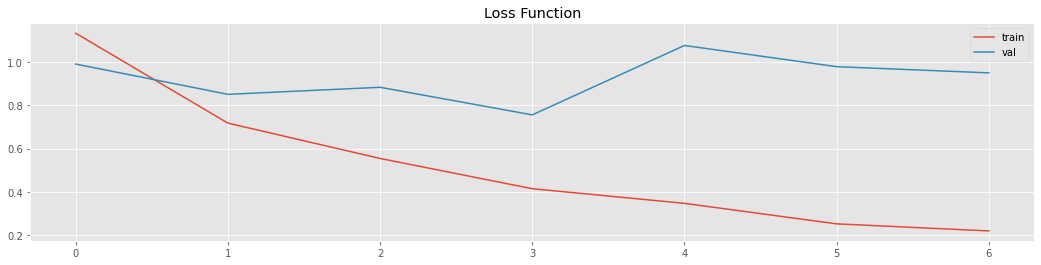

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['loss'], label = 'train')
plt.plot(data_his['val_loss'], label = 'val')
plt.legend()
plt.title('Loss Function')
plt.show()
fig.savefig("Loss Function",dpi=700)


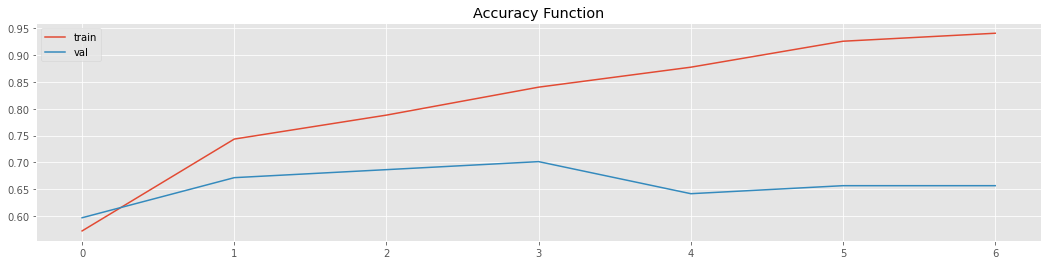

In [ ]:
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['accuracy'], label = 'train')
plt.plot(data_his['val_accuracy'], label = 'val')
plt.legend()
plt.title('Accuracy Function')
plt.show()
fig.savefig("Accuracy Function",dpi=700)

In [ ]:
train_images.class_indices.keys()

dict_keys(['mono', 'neutral', 'pastel', 'toneon'])

In [ ]:
train_images.class_indices.values()

dict_values([0, 1, 2, 3])

In [ ]:
model.save("/content/drive/MyDrive/2023 KUIAI 해커톤/woman_tone_tag_classificator.h5")

# 모델 결과 검증

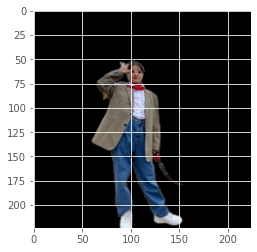

1/1 [==============================] - 0s 176ms/step
[2]


In [ ]:
from tensorflow.keras.preprocessing import image
dir_path = '/content/drive/MyDrive/2023 KUIAI 해커톤/influ_girl_half/@belleofcloset_14_half.png'

img = image.load_img(dir_path, target_size=(224,224))
plt.imshow(img)
plt.show()
    
X = image.img_to_array(img)
X = np.expand_dims(X,axis=0)
images = np.vstack([X])
predictions = np.argmax(model.predict(images), axis=1)
print(predictions)